## About

https://www.kaggle.com/nakulsingh1289/face-expression-detection-from-scratch

The data set consits of 48x48 pixel images of faces. There is a total of seven categories with a categorizing number:

Angry (0) Disgust (1) Fear (2) Happy (3) Sad (4) Surprise (5) Neutral (6)

### Import packages

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13021508912477109175
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6597931449
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7274888835179845741
physical_device_desc: "device: 0, name: GeForce GTX 1070, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
import numpy as np
import pandas as pd
#import seaborn as sns
import matplotlib.pyplot as plt
import os
from os import path

%matplotlib inline

from keras.utils import to_categorical
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from PIL import Image

In [3]:
#Figure sizes are 48x48 pixels
pic_size = 48

In [4]:
dir_path = os.getcwd() + "/data/"
print(dir_path)

C:\Users\berna\Documents\GitHub\Emotiondetection/data/


In [5]:
#load df
df = pd.read_csv(dir_path + "icml_face_data.csv")

#create a dict correlating each expression to the right number
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [6]:
df.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [7]:
val_count = df.emotion.value_counts()
val_count = val_count.rename(index=emotions)
val_count.to_frame().style.bar()

,emotion
Happy,8989
Neutral,6198
Sad,6077
Fear,5121
Angry,4953
Surprise,4002
Disgust,547


### Some helper functions to plot and prepare data

In [8]:
# This function will help me plot an example image of each emotion
def plot_all_emotions():
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(7):
        idx = df[df['emotion']==i].index[i]
        axs[i].imshow(train_images[idx][:,:,0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

In [9]:
def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels and pixel data
        output: image and label array """
    
    # Creates two np arrays.
    # 1st is an array with the length of the dataframe, and each element in the array is a 48x48 array
    image_array = np.zeros(shape=(len(data), 48, 48))
    # 2nd is an array that creates an array where each element is a number representing the emotion from the dataframe
    image_label = np.array(list(map(int, data['emotion'])))
    
    # We iterate through the dataframe row by row, inserting each row as element in the array and separating
    # each value separated with a space and adding it as an element.
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

In [10]:
train_image_array, train_image_label = prepare_data(df[df[' Usage']=='Training'])
val_image_array, val_image_label = prepare_data(df[df[' Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(df[df[' Usage']=='PublicTest'])

In [11]:
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
train_images = train_images.astype('float32')/255
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
val_images = val_images.astype('float32')/255
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))
test_images = test_images.astype('float32')/255

In [12]:
# We transform the the labels to proper vectors to make it usable for the model to use
train_labels = to_categorical(train_image_label)
val_labels = to_categorical(val_image_label)
test_labels = to_categorical(test_image_label)

### Plot examples images of all emotions from the training data

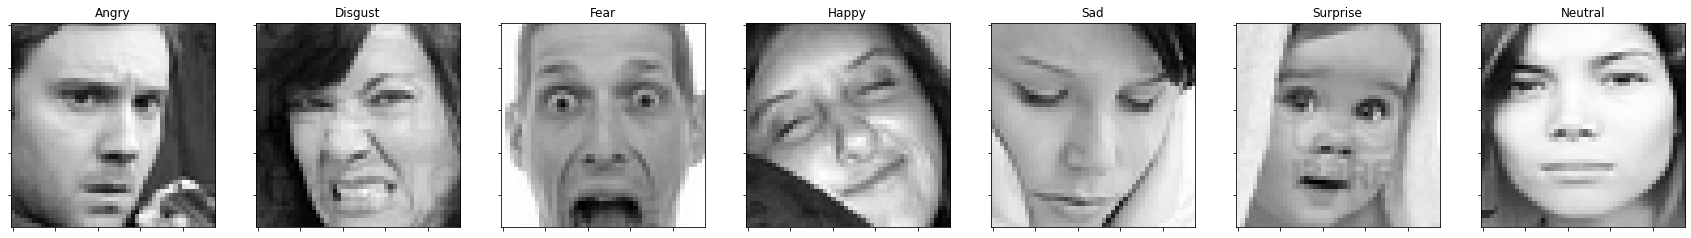

In [13]:
plot_all_emotions()

### Image augmentation using keras ImageDataGenerator

In [27]:
# First I save every image in a folder because this is what ImageDatagenerator requires to augment
# I use a package that easily saves image arrays to png called Pillow (PIL)
# https://github.com/drj11/pypng/'

for num, images in enumerate(train_image_array):
    class_folder = emotions[int(train_image_label[num])]
    im = Image.fromarray(images.astype(np.uint8))
    #save them each image in right folder correlating to each class
    if path.exists("images/train/" + class_folder):
        im.save('images/train/'+ class_folder + f'/{num}.png')  
    else:
        os.mkdir('images/train/' + class_folder)
        im.save('images/train/'+ class_folder + f'/{num}.png')  
    
for num, images in enumerate(val_image_array):
    class_folder = emotions[int(val_image_label[num])]
    im = Image.fromarray(images.astype(np.uint8))
    #save them each image in right folder correlating to each class
    if path.exists("images/validation/" + class_folder):
        im.save('images/validation/'+ class_folder + f'/{num}.png')  
    else:
        os.mkdir('images/validation/' + class_folder)
        im.save('images/validation/'+ class_folder + f'/{num}.png') 

In [14]:
# augmentation

batch_size = 128
base_path = "images/"

train_datagen = ImageDataGenerator(rescale = 1.0/255.0,
                                  width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   rotation_range = 20,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale= 1.0/255)

train_generator = train_datagen.flow_from_directory(base_path + "train/",
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = validation_datagen.flow_from_directory(base_path + "validation/",
                                                    target_size=(56,56),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


### Training the model

In [15]:
# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(56, 56,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

print(model.summary())

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       5

In [16]:
# number of epochs to train the NN
epochs = 50

# checkpoint to save best model
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit(train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

Epoch 1/50
224/224 [==============================] - 52s 204ms/step - loss: 2.2030 - accuracy: 0.1965 - val_loss: 1.9416 - val_accuracy: 0.2453

Epoch 00001: val_accuracy improved from -inf to 0.24526, saving model to model_weights.h5
Epoch 2/50
224/224 [==============================] - 18s 79ms/step - loss: 1.9353 - accuracy: 0.2396 - val_loss: 1.9385 - val_accuracy: 0.2556

Epoch 00002: val_accuracy improved from 0.24526 to 0.25558, saving model to model_weights.h5
Epoch 3/50
224/224 [==============================] - 17s 77ms/step - loss: 1.8630 - accuracy: 0.2654 - val_loss: 1.8477 - val_accuracy: 0.2785

Epoch 00003: val_accuracy improved from 0.25558 to 0.27846, saving model to model_weights.h5
Epoch 4/50
224/224 [==============================] - 17s 77ms/step - loss: 1.8245 - accuracy: 0.2762 - val_loss: 1.6786 - val_accuracy: 0.3309

Epoch 00004: val_accuracy improved from 0.27846 to 0.33092, saving model to model_weights.h5
Epoch 5/50
224/224 [==============================

224/224 [==============================] - 19s 83ms/step - loss: 1.1440 - accuracy: 0.5612 - val_loss: 1.0799 - val_accuracy: 0.5960

Epoch 00037: val_accuracy did not improve from 0.60770
Epoch 38/50
224/224 [==============================] - 18s 82ms/step - loss: 1.1346 - accuracy: 0.5695 - val_loss: 1.0651 - val_accuracy: 0.5940

Epoch 00038: val_accuracy did not improve from 0.60770
Epoch 39/50
224/224 [==============================] - 18s 82ms/step - loss: 1.1217 - accuracy: 0.5723 - val_loss: 1.0095 - val_accuracy: 0.6189

Epoch 00039: val_accuracy improved from 0.60770 to 0.61886, saving model to model_weights.h5
Epoch 40/50
224/224 [==============================] - 18s 82ms/step - loss: 1.1277 - accuracy: 0.5705 - val_loss: 1.1145 - val_accuracy: 0.5759

Epoch 00040: val_accuracy did not improve from 0.61886
Epoch 41/50
224/224 [==============================] - 19s 84ms/step - loss: 1.1105 - accuracy: 0.5774 - val_loss: 1.0462 - val_accuracy: 0.6060

Epoch 00041: val_accurac

## Visualize the training, testing accuracy and loss

In [24]:
def visualize_model(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(1, len(acc) + 1)
    
    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    


    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

def get_best_epcoh(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

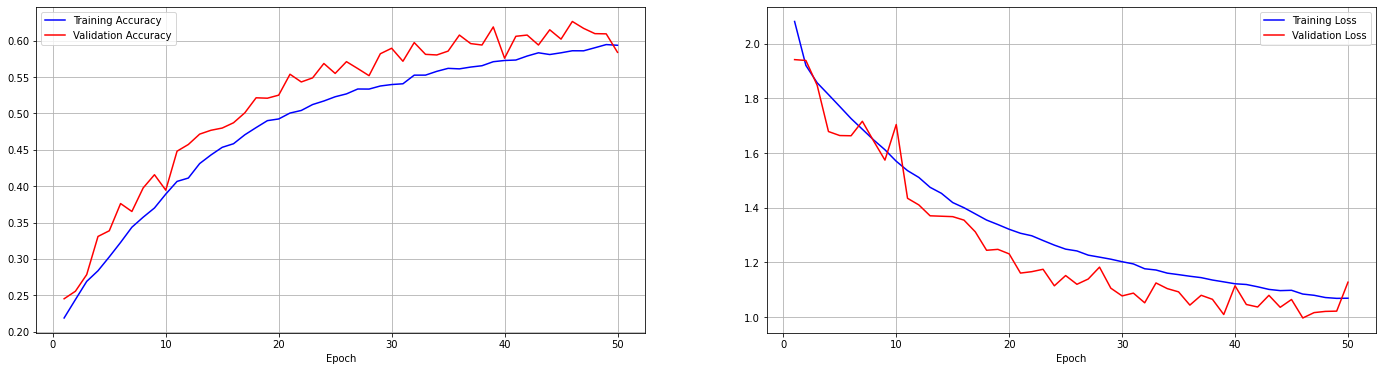

Best Validation Accuracy Score 0.62640, is for epoch 46


In [25]:
visualize_model(history)
best_epoch = get_best_epcoh(history)